# Importing necessary libraries

In [1]:
#Setting up environment with initial libraries needed for importing, cleaning, and initial visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats





In [3]:
# Load dataset and inspect the make sure it loaded correctly
df = pd.read_csv('csv_files/kc_house_data.csv')


# Data Cleaning

In [3]:
#Checking data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [4]:
df.sqft_basement.unique()[:5]

array(['0.0', '400.0', '910.0', '1530.0', '?'], dtype=object)

In [5]:
df.date.unique()[:5]

array(['10/13/2014', '12/9/2014', '2/25/2015', '2/18/2015', '5/12/2014'],
      dtype=object)

In [6]:
df.waterfront.unique()[:5]

array([nan,  0.,  1.])

In [7]:
df.condition.unique()[:5]

array([3, 5, 4, 1, 2])

In [8]:
df.price.unique()[:5]

array([221900., 538000., 180000., 604000., 510000.])

# Data Scrubbing

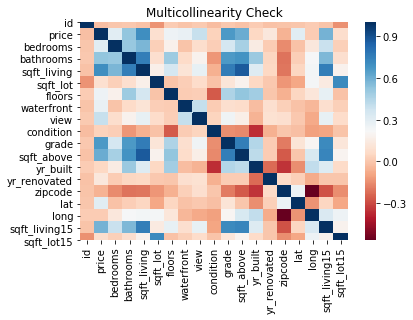

In [9]:
#First check for multicollineraity pre-scrubbing
color_map = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Multicollinearity Check')
_ = sns.heatmap(df.corr(), cmap="RdBu")

In [10]:
df['sqft_living'].value_counts().head()

1300    138
1400    135
1440    133
1660    129
1010    129
Name: sqft_living, dtype: int64

In [11]:
df['sqft_above'].value_counts().head()

1300    212
1010    210
1200    206
1220    192
1140    184
Name: sqft_above, dtype: int64

In [12]:
df['sqft_basement'].value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

In [13]:
#Homes without a basement have a value of "?". In these homes sqft_living and sqft_above
#are the same. To assign a value where sqft_basement == '?', performing calculation
#below
sqfeet = df['sqft_basement'] == '?'
df.loc[sqfeet, 'sqft_basement'] = (df['sqft_living'] - df['sqft_above'])
df[['sqft_basement', 'sqft_living', 'sqft_above']].head()

,sqft_basement,sqft_living,sqft_above
0,0.0,1180,1180
1,400.0,2570,2170
2,0.0,770,770
3,910.0,1960,1050
4,0.0,1680,1680


In [14]:
#Waterfront and yr_renovated have many null values and I may drop them
#View has 63, not sure yet if I should keep that variable since it is so small 
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [15]:
#Drop id column, numbers of no use
df_new = df.drop(['id'], axis=1, inplace=True)



In [16]:
#Drop sqft_above, and sqft_living15 due to multicolliniearatity
df_new = df.drop(['sqft_above', 'sqft_living15'], axis=1)
df_new.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,lat,long,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,0.0,1955,0.0,47.5112,-122.257,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,400.0,1951,1991.0,47.7210,-122.319,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,0.0,1933,NaN,47.7379,-122.233,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,910.0,1965,0.0,47.5208,-122.393,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,0.0,1987,0.0,47.6168,-122.045,7503


In [17]:
#Drop due to mostly null values. Keeping waterfront since that is a sought-out feature 
#for homebuyers
df_new= df.drop(['yr_renovated', 'view'], axis=1)
df_new.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,1955,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503


# Normalizing Data

Text(0, 0.5, 'Frequency')

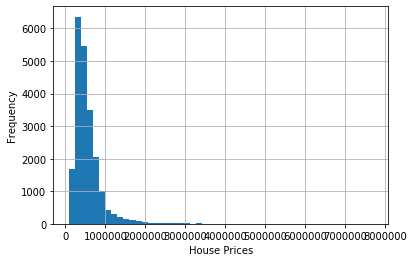

In [18]:
df_new['price'].hist(bins=50)
plt.xlabel("House Prices")
plt.ylabel("Frequency")

In [19]:
#From above clearly price is not normally distributed
#Perform log transformation to normally distribute the target variable
df_new['log_price'] = df['price'].apply(lambda x: np.log(x))


Text(0, 0.5, 'Frequency')

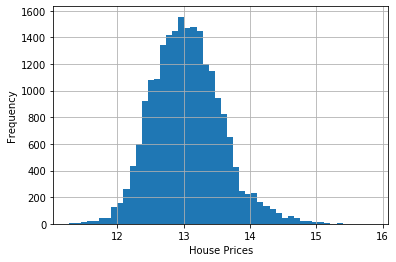

In [20]:
df_new['log_price'].hist(bins=50)
plt.xlabel("House Prices")
plt.ylabel("Frequency")

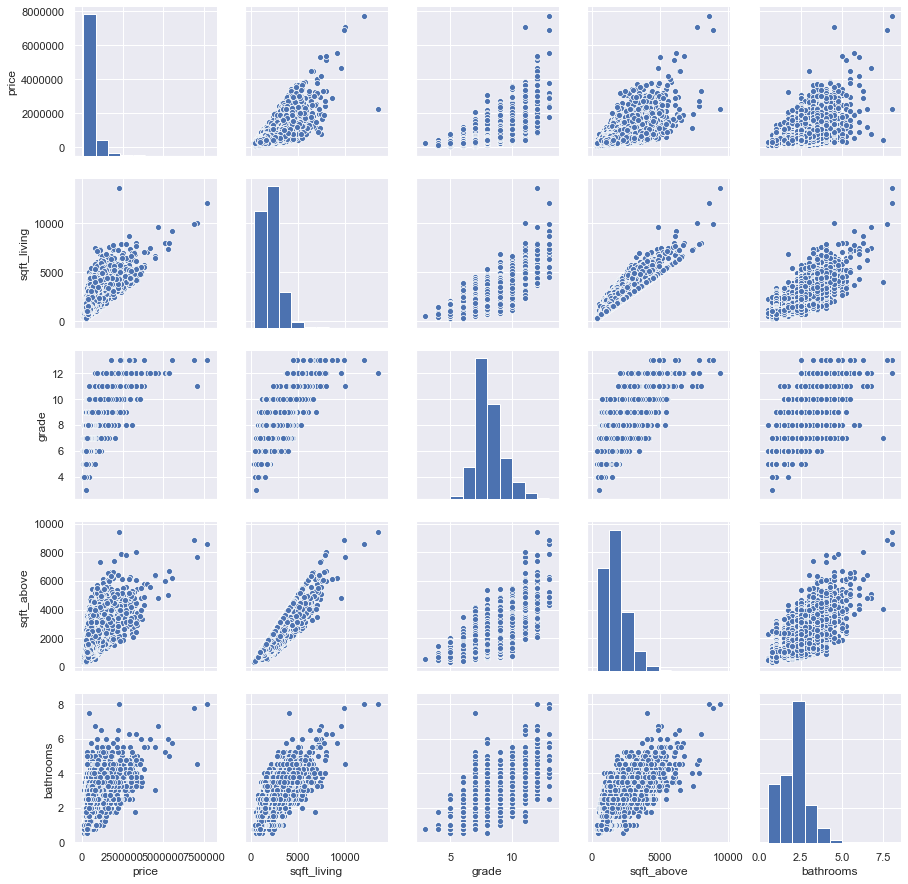

In [21]:
sns.set()
cols = ['price', 'sqft_living', 'grade', 'sqft_above', 'bathrooms']
sns.pairplot(df[cols], height = 2.5)
plt.show();

## Checking for Multicollinearity and Exploratory Data Analysis

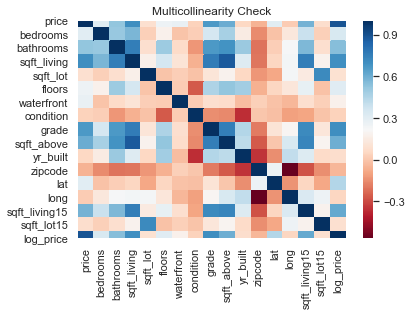

In [22]:
#Check for multicollineraity after-scrubbing
#color_map = sns.diverging_palette(220, 10, as_cmap=True)
#plt.title('Multicollinearity Check2')
#df_new = sns.heatmap(df_new.corr(), cmap="RdBu")
#sns.heatmap(df_new.corr(), center=0)

color_map = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Multicollinearity Check')
df_new = sns.heatmap(df_new.corr(), cmap="RdBu")
#Map shows collineraity with price, bedrooms, bathrooms, & sqft_living

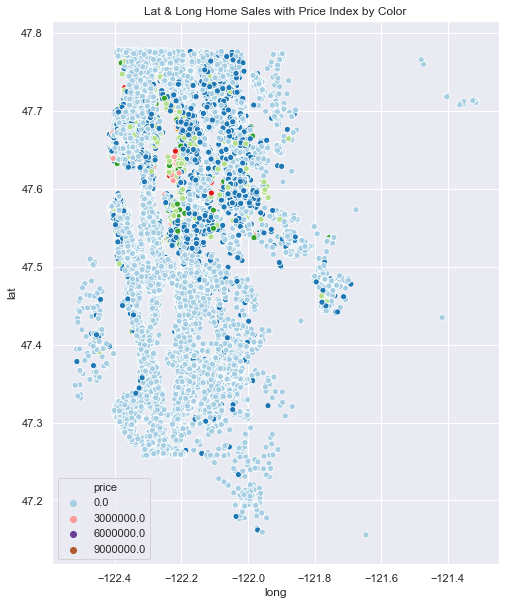

In [23]:
#Sales price by location
plt.figure(figsize=(8,10))
sns.scatterplot(x='long', y='lat', hue='price', data=df, palette='Paired')
plt.title('Lat & Long Home Sales with Price Index by Color')
plt.legend(fancybox=True);

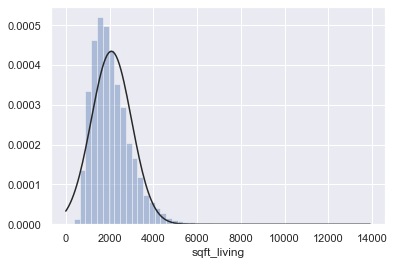

<Figure size 432x288 with 0 Axes>

In [24]:
from scipy.stats import norm
from scipy import stats
sns.distplot(df['sqft_living'], fit=norm, bins=50, kde=False);
fig = plt.figure()


In [25]:
#Log transformation to normalize
df['sqft_living'] = np.log(df['sqft_living'])

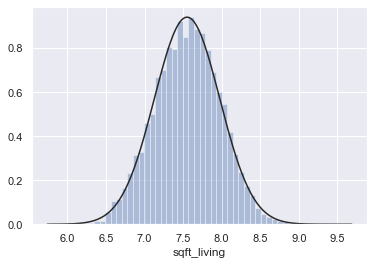

<Figure size 432x288 with 0 Axes>

In [26]:
sns.distplot(df['sqft_living'], fit=norm, bins=50, kde=False);
fig = plt.figure()

In [27]:
df2 = df.groupby(by = 'price').mean()


In [28]:
df2.shape

(3622, 17)

In [29]:
df2.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,,,,,,,,,,,,,,,,,
78000.0,2.0,1.00,6.659294,16344.0,1.0,0.0,0.0,1.0,5.0,780.0,1942.0,NaN,98168.0,47.4739,-122.280,1700.0,10387.0
80000.0,1.0,0.75,6.063785,5050.0,1.0,NaN,0.0,2.0,4.0,430.0,1912.0,0.0,98014.0,47.6499,-121.909,1200.0,7500.0
81000.0,2.0,1.00,6.593045,9975.0,1.0,NaN,0.0,1.0,5.0,730.0,1943.0,0.0,98168.0,47.4808,-122.315,860.0,9000.0
82000.0,3.0,1.00,6.756932,10426.0,1.0,0.0,0.0,3.0,6.0,860.0,1954.0,0.0,98146.0,47.4987,-122.341,1140.0,11250.0
82500.0,2.0,1.00,6.253829,22334.0,1.0,0.0,0.0,2.0,5.0,520.0,1951.0,0.0,98168.0,47.4799,-122.296,1572.0,10570.0


In [40]:
cats = []
conts = []

for col in df2.columns:
    if df[col].nunique() <= 75:
        cats.append(col)
    else:
        conts.append(col)
        
print(cats)
print(conts)

['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_renovated', 'zipcode']
['sqft_living', 'sqft_lot', 'sqft_above', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


,sqft_living,sqft_lot,sqft_above,yr_built,lat,long,sqft_living15,sqft_lot15
count,3622.000000,3622.000000,3622.000000,3622.000000,3622.000000,3622.000000,3622.000000,3622.000000
mean,7.576973,13518.697151,1886.156494,1973.737274,47.554186,-122.206692,2047.271538,11457.110067
std,0.418137,25672.064999,855.732196,25.222553,0.123922,0.115997,666.834769,16762.994598
min,6.040255,635.000000,420.000000,1900.000000,47.189600,-122.505000,750.000000,659.000000
25%,7.306123,5766.500000,1290.277778,1958.875000,47.476813,-122.288000,1570.000000,5782.500000
50%,7.568378,8137.500000,1656.136364,1974.000000,47.581850,-122.216585,1905.000000,7997.500000
75%,7.859413,12243.286932,2336.875000,1992.000000,47.643337,-122.149000,2430.000000,11087.500000
max,9.513404,641203.000000,9410.000000,2015.000000,47.777500,-121.698000,6110.000000,291416.000000


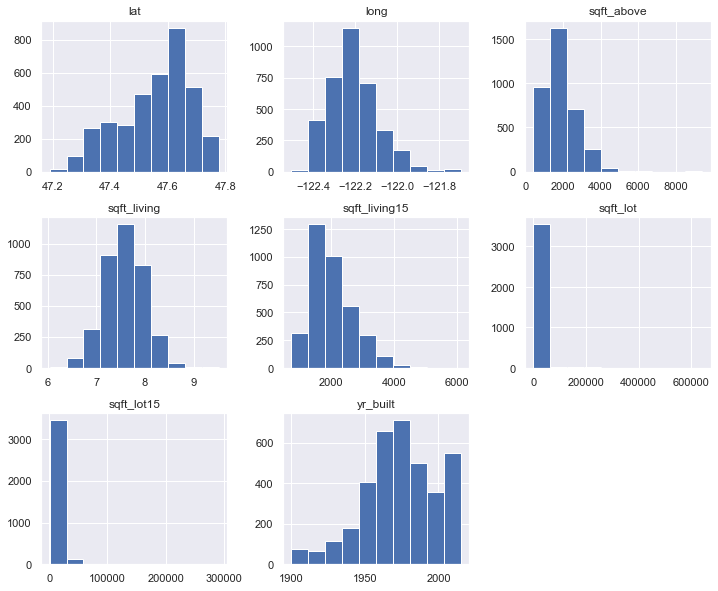

In [41]:
df_conts = df2.loc[:,conts]
df_conts.hist(figsize=(12,10))
df_conts.describe()

# Modeling *reword everything to make my own from here*

In [32]:
subs = [(' ', '_'),('.',''),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

In [43]:
df2.columns = [col_formatting(col) for col in df2.columns]

In [44]:
list(df2.columns)

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [38]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3622 entries, 78000.0 to 7700000.0
Data columns (total 17 columns):
bedrooms         3622 non-null float64
bathrooms        3622 non-null float64
sqft_living      3622 non-null float64
sqft_lot         3622 non-null float64
floors           3622 non-null float64
waterfront       3391 non-null float64
view             3613 non-null float64
condition        3622 non-null float64
grade            3622 non-null float64
sqft_above       3622 non-null float64
yr_built         3622 non-null float64
yr_renovated     3238 non-null float64
zipcode          3622 non-null float64
lat              3622 non-null float64
long             3622 non-null float64
sqft_living15    3622 non-null float64
sqft_lot15       3622 non-null float64
dtypes: float64(17)
memory usage: 509.3 KB


In [47]:
# Defining the problem
outcome = 'list_price'
x_cols = list(df.columns)


In [ ]:
df['price'].hist(bins=50)
plt.xlabel("House Prices")
plt.ylabel("Frequency")

In [ ]:
df['sqft_living'].hist(bins=50)
plt.xlabel("Sqft of living area")
plt.ylabel("Frequency")

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 5)
sns.regplot(x="sqft_living", y="price", data=df,ax=ax1)
sns.regplot(x="yr_built", y="price", data=df,ax=ax2)

In [ ]:
# Looking for duplicates and missing values
duplicate_rows = df[df.duplicated()]
print(f"The df has {len(duplicate_rows)} duplicate rows.")

duplicate_id = df[df.duplicated('id')]
print(f'There are {len(duplicate_id)} duplicate values of id. ' 
      f'This represents {round(len(duplicate_id)/len(df),3)*100}% of all entries.')

for col in df:
    v = df[col].isna().sum()
    if v > 0:
        print(f'The column "{col}" has {v} missing values.')